In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
data = pd.read_csv(r"C:\Users\samue\OneDrive\Desktop\Data Science FP\Preprocessing\2021-2024 data.csv")

# Define the features and target
features = ['Pos','Age','90s','GCA90','Sh/90','SoT/90','G/Sh','G/SoT','PK','xG/90','np:G-xG','Dist','Squad','Nation', 'Season','Cluster']
target = 'Gls/90'
# Apply a cap to the target variable
data['Gls/90'] = data['Gls/90'].apply(lambda x: min(x, 1.2))

# Encode categorical features
label_encoders = {}
for col in ['Nation', 'Pos', 'Squad', 'Season']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define features (X) and target (y)
X = data[features]
y = data[target]



Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6}
Test Mean Squared Error: 0.000650969441979636
Test R-squared: 0.986394873226316
    Feature  Importance
6      G/Sh    0.390928
7     G/SoT    0.204583
5    SoT/90    0.169870
9     xG/90    0.090390
4     Sh/90    0.035056
2       90s    0.035011
8        PK    0.025839
10  np:G-xG    0.017944
14   Season    0.007348
13   Nation    0.005006
1       Age    0.003863
12    Squad    0.003818
3     GCA90    0.003181
0       Pos    0.002614
11     Dist    0.002535
15  Cluster    0.002013


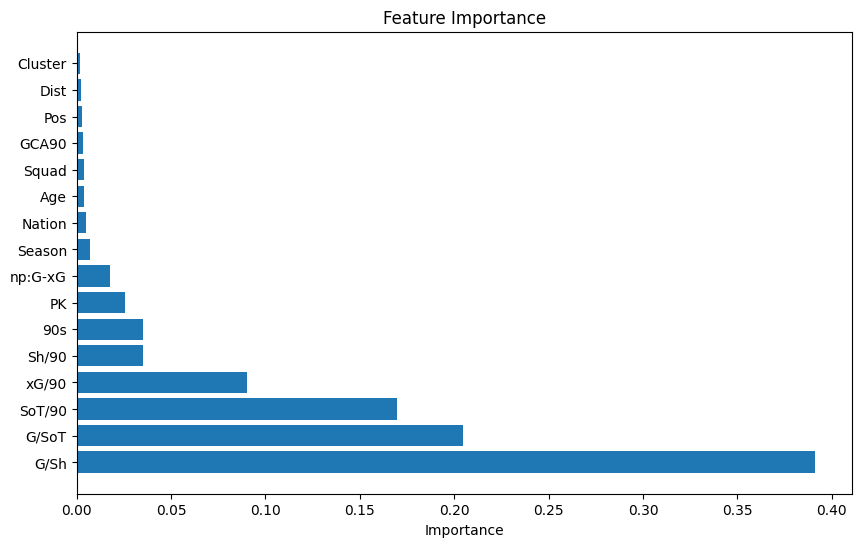

In [3]:
# Initialize the XGBRegressor model
model = XGBRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # Learning rate
    'max_depth': [3, 5, 7, 10],                 # Maximum depth of trees
    'subsample': [0.6, 0.8, 1.0],               # Fraction of samples for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features for each tree
    'min_child_weight': [1, 3, 5],              # Minimum sum of instance weight
    'gamma': [0, 0.1, 0.2],                    # Minimum loss reduction required to make a partition
}

# Use GridSearchCV to tune hyperparameters with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
                           

# Fit the model with the best hyperparameters
grid_search.fit(X, y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Train-test split evaluation:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model on training set
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test R-squared: {test_r2}")

# Feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


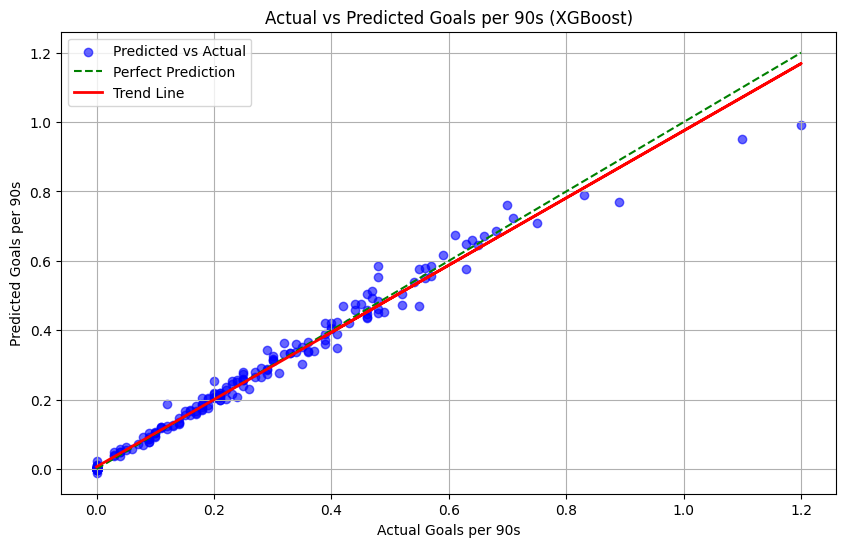

In [4]:
import numpy as np 
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6) 

# Plot the line of perfect prediction 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', label='Perfect Prediction', linestyle='--')

# Fit a trend line using a linear regression 
from sklearn.linear_model import LinearRegression
trend_model = LinearRegression()
y_test_reshaped = np.array(y_test).reshape(-1, 1)  
trend_model.fit(y_test_reshaped, y_pred)  
trend_line = trend_model.predict(y_test_reshaped)  

# Add the trend line to the plot
plt.plot(y_test, trend_line, color='red', label='Trend Line', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Actual Goals per 90s')
plt.ylabel('Predicted Goals per 90s')
plt.title('Actual vs Predicted Goals per 90s (XGBoost)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

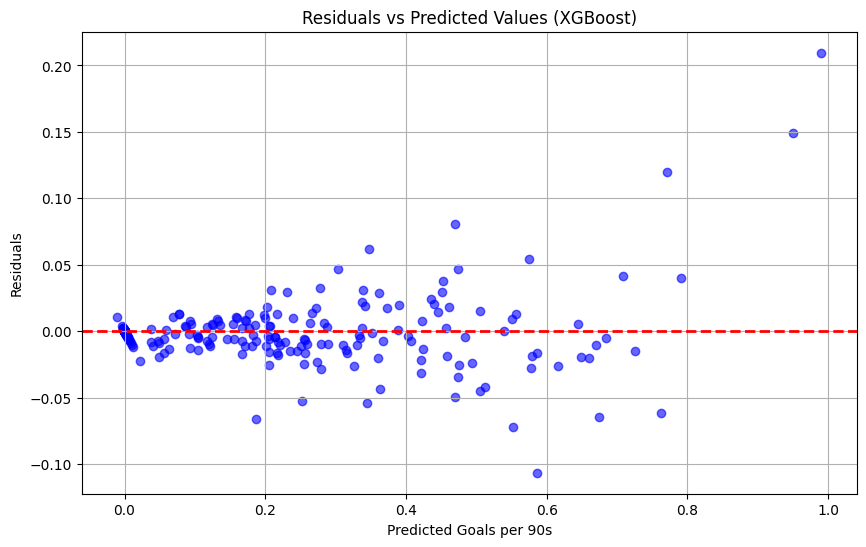

In [5]:
# Formula for calculating the residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Goals per 90s')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (XGBoost)')
plt.grid(True)
plt.show()